### Import Packages

In [1]:
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import pickle
import nltk
from sklearn.feature_extraction import text 
import statsmodels.api as smf
from patsy import dmatrices,dmatrix
import scipy

%matplotlib inline
pd.set_option('display.max_columns', 70)

/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Run the scraper to download comments from twitch videos. 
-input Video ID and output folder. 

In [2]:
# !python Twitch-Chat-Downloader/app.py -v 263875450 --format irc --output ~/Downloads/streams

### Import Scraped Data

In [3]:
videofile='video_logs/v263708483.log'
data2=pd.read_fwf(videofile)
data2.tail()
data=(data2.iloc[:,:2])
data.columns=["time","comment"]

### Extract video number from the file name

In [4]:
video_num=int(re.findall(r'\d+',videofile)[0])


### Predefine Functions that will be later referenced in the notebook.

In [5]:
def seconds_to_time(seconds):
    """ Set seconds to actul time used for plotting axis"""
    hour_play=seconds//3600
    minute_play=(seconds%3600) // 60
    second_play=(seconds%3600)%60 
    return str(hour_play)+":"+str(minute_play)+":"+str(second_play)


def plot_topic_matrix(model,vectorizer_feature):
    """ plots each topic with top words and percent% """
    disp_topics = pd.DataFrame()
    prob_comp = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(prob_comp):
        top_indices = topic.argsort()[:-30 - 1:-1]
        top_words = [f"{vectorizer_feature[i]} {topic[i]:.1%}" for i in top_indices]
        disp_topics[f"Topic {topic_idx}"] = top_words
    return disp_topics

def print_top_words(model, feature_names, n_top_words):
    """  use  plot_topic_matrix """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

    
def display_topics(model, feature_names, no_top_words):
    """ use plot_topic_matrix """
    for topic_idx, topic in enumerate(model.components_):
        print (" Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def wordcloud_str(string2):
    """ plot a wordcloud just need a string input"""
    wordcloud = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='white',
                              width=2400,
                              height=1000
                             ).generate(string2)


    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    
def analyze_coef(df_with_cols,model,num_points):
    feat = df_with_cols.columns
    coef = model.coef_.flatten()
    sort_i = np.argsort(-np.abs(coef))

    plt.figure(figsize=(10,5))
    n_plot = num_points
    ind = np.arange(n_plot)

    plt.scatter(ind, coef[sort_i][:n_plot])
    plt.xticks(ind, feat[sort_i][:n_plot], rotation=90);
    plt.title("Top coefficients for CV-optimized lasso model")
    plt.ylabel("coefficient");

### Convert col to delta time  (HMS conversion) 

In [6]:
new_time=data.time.str.replace(']'  ,"")
new_time2=new_time.str.replace('[' ,"")
new_time_col=pd.to_timedelta(new_time2)

### Add Seconds Count

In [7]:
working_df=pd.concat([data,new_time_col],axis=1)
working_df_v2=working_df.iloc[:,1:]
working_df_v2['seconds']=working_df_v2.time.apply(lambda row:  (row.total_seconds()))
working_df_v3=(working_df_v2)

### Create Groups of Seconds and cheer per second

In [8]:
group_seconds=pd.DataFrame(working_df_v3.groupby(['seconds']).agg(['count']))
group_seconds_v2=group_seconds.reset_index()
group_seconds_v3=group_seconds_v2.iloc[:,:2]
group_seconds_v3.columns=['seconds','counts']
len(group_seconds_v3)

17541

### Additional Data Cleaning: Split User and comments

In [9]:
df4 = pd.DataFrame(working_df_v3.comment.str.split('>',1).tolist(),
                                   columns = ['user','comment'])
df5=working_df_v3.iloc[:,1:]
df6=pd.concat([df4,df5], axis=1)
df7 = pd.DataFrame(df6.groupby(['time'])['comment'].apply(list)).reset_index()
df8=df7.set_index('time')
df8.head()
print(len(df6))

47864


### Group Video Data by 30 sec interval, aggregate and bin comments. 
#### -Last part of DataFrame manipulation 

In [10]:
df9=df8.resample('30s', how=sum)
df9['str_comments']=df9.comment.apply(lambda row:  str(row))
df10= df9.drop(["comment"], axis=1)
df11=pd.DataFrame(df10.str_comments.str.lower())
df12=pd.DataFrame(df11.str_comments.str.replace(r'ninja', ''))
df12.str_comments.replace(r'creep','', regex=True,inplace=True )
df12.str_comments.replace(r'crinja','', regex=True,inplace=True )

df12.str_comments.replace(r'[^a-zA-Z\s]','', regex=True,inplace=True )


/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


### Part Two : Data Analysis 

### Visualize the Bins

In [11]:
df12.str_comments[2]

' ayy  yooooo  hi    viewers lol  first  hey  thirst thirst cash cash thirst cash            hi  yoooooooo  fortone  im here bois  pon  hey  and now i wait for  years  pon  hey  you the man  hiiiio  cuz u a real ass woman an i like it  k  we out here  aww aww  followage  yaaaa  if you have bttv type followed  you can get the bttv add on here httpsgooglubbaaw  hey   bla bla bla  hey  whats up  pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon  hey  uhi  im lit  we out heree boiis  whatssss uppppppppp dawgggggggg  ayye  pon  hi  scaredycat scaredycat scaredycat       popcorn  s cash s popcorn rekt prime prime hs popcorn rekt popcorn s s s s troll cash cash cash  sad  hours  we out here  ayy    muooo  hey pon  litty  aye  before the ponpon n shit    whats up  pon flipthis flipthis flipthis flipthis flipthis  pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon pon                 h h h h h h h h h h h h h h h

#### Time to seconds function: Manual Video Validation

In [12]:
time = "01:14:32"
sum(x * int(t) for x, t in zip([3600, 60, 1], time.split(":"))) 

4472

### Insert the number of seconds that the user would like to start the video play at: 
 


In [13]:
### Convert seconds to time format for the URL
## fail_1 manually declared variable by the user. Takes input in seconds, used to start a video at a specific moment. 
fail_1=10
fail_2= fail_1*30

In [14]:
time_play=(datetime.timedelta(seconds=fail_2))
hour_play=fail_2//3600
minute_play=(fail_2%3600) // 60
second_play=(fail_2%3600)%60 

import IPython
url = 'some url....'
iframe = f'''

<iframe
    src="http://player.twitch.tv/?video=v{str(video_num)}&t={hour_play}h{minute_play}m{second_play}s"
    height="400"
    width="700"
    frameborder="0"
    scrolling="no"
    allowfullscreen="true" >
</iframe>
'''

# Comment out if you would not like the video to play
# IPython.display.HTML(iframe)

### Text Blob Sentiment Analysis:
ex  TextBlob("it's so awesome.").sentiment
    - Positive Sentiment

### Agg Data for Sentiment Analysis: 

In [15]:
plot_video_comments=working_df_v3.copy()
plot_video_comments['number']=1
plot_video_comments_v2=plot_video_comments.set_index('time')
plot_video_comments_v3=plot_video_comments_v2.resample('30s', how=sum)
plot_video_comments_v3['interval']=[i for i in range(len(plot_video_comments_v3))]

/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  after removing the cwd from sys.path.


### Plot Sentiment over the Video Timeline, Smooth out the borders. 

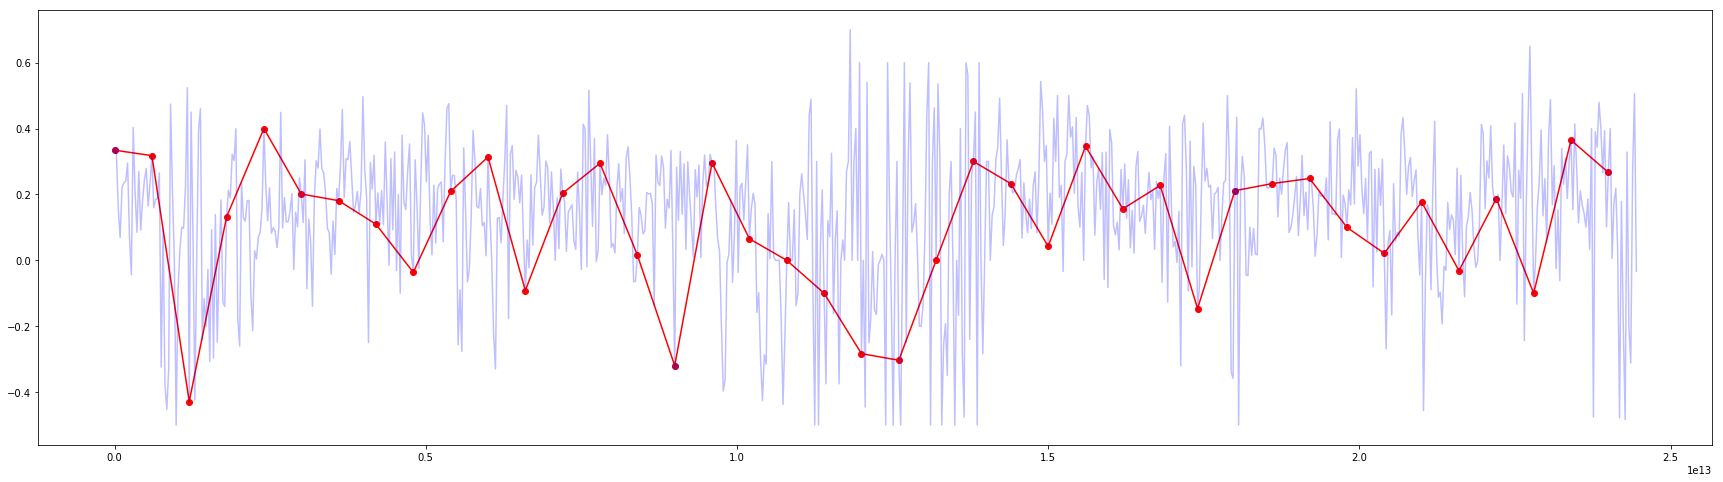

In [16]:
# Use to plot graph axis as time hms
plot_index=[str(x)[7:] for x in df10.index]

polarity_list=[]
for i in range(len(df10)):
#     print(i)
#     print(TextBlob(df10.str_comments[i]).sentiment)
    extract_blob=(TextBlob(df12.str_comments[i]).sentiment)
    polarity_list.append(extract_blob.polarity)


plt.figure(figsize=(30,8))
plt.plot(df12.index[0::20],polarity_list[0::20],'ro-')

plt.plot(df12.index,polarity_list,'bo-',markevery=300, alpha=0.25)

### NMF TFIDF


In [17]:
# Below Script is used to create a vectorizer model. But the vectorizer is already created so we are going to import using pickle. 

# tfidf_vectorizer = TfidfVectorizer(min_df=.1, max_df=.9, stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
# tfidf_matrix = tfidf_vectorizer.fit_transform(df12.str_comments)

# Export the model once created. 

# import pickle 
# with open('vect.pkl', 'wb') as file:
#     pickle.dump(tfidf_vectorizer,file)

### Create a Sparse Matrix for the documents: 
##### Use the vectorizer to transform the documents into sparse matrix

In [18]:
import pickle
with open("pickle_files/vect.pkl", 'rb') as picklefile:
    tfidf_vectorizer = pickle.load(picklefile)

#Transfom is needed is used when loading model. Fit_Transform for creating models.
tfidf_matrix = tfidf_vectorizer.transform(df12.str_comments)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#Visualize top 4 features
tfidf_feature_names[1:5]

['adore', 'aim', 'amazing', 'available']

##### Visualize TFIDF Sprase Matrix: Optional

In [19]:
print(tfidf_matrix.shape)
pd.DataFrame(tfidf_matrix.toarray()).head(10)

(816, 149)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148
0,0.000000,0.044573,0.000000,0.040061,0.000000,0.000000,0.000000,0.0,0.000000,0.156211,0.739310,0.000000,0.000000,0.000000,0.000000,0.0,0.057193,0.0,0.043830,0.000000,0.0,0.071003,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.041766,0.000000,0.000000,0.000000,0.000000,0.103627,0.0,0.058571,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.135160,0.038231,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.052979,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.108128,0.0
1,0.121015,0.000000,0.000000,0.000000,0.123888,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.093352,0.083327,0.0,0.529297,0.077758,0.0,0.100113,0.000000,0.089833,0.0,0.109172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.076988,0.000000,0.110357,0.0,0.124750,0.104250,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.095958,0.000000,0.000000,0.0,0.096585,0.0,0.000000,0.000000,0.0,0.099883,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.045568,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.210270,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.076558,0.000000,0.000000,0.000000,0.025035,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.049261,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015244,0.0,0.000000,0.262408,0.063688,0.000000,0.009579,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.009435,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.010879,0.010879,0.000000,0.000000,0.000000,0.000000,...,0.010794,0.000000,0.000000,0.009342,0.010021,0.000000,0.0,0.000000,0.012649,0.0,0.0,0.0,0.012557,0.000000,0.000000,0.069162,0.000000,0.000000,0.015465,0.019971,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.013972,0.0
4,0.000000,0.145848,0.000000,0.015422,0.000000,0.075147,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.007027,0.0,0.000000,0.010531,0.000000,0.0,0.000000,0.008102,0.008102,0.000000,0.007901,0.000000,0.000000,...,0.000000,0.066525,0.000000,0.000000,0.007463,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.102874,0.008709,0.017344,0.000000,0.055048,0.000000,0.000000,0.037184,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.011353,0.0,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.083712,0.000000,0.009157,0.000000,0.013126,0.0,0.000000,0.0,0.000000,0.009665,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.070988,0.000000,0.144197,...,0.010318,0.000000,0.000000,0.000000,0.009579,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.132229,0.000000,0.000000,0.000000,0.028636,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.01253,0.287660,0.0,0.018252,0.000000,0.0,0.013356,0.0
6,0.000000,0.000000,0.000000,0.006793,0.000000,0.000000,0.000000,0.0,0.009511,0.033110,0.219381,0.000000,0.000000,0.000000,0.009009,0.0,0.242447,0.0,0.007432,0.000000,0.0,0.000000,0.006190,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.007138,0.007138,0.000000,0.153130,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.006129,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.016165,0.0000

### Assign Number of Topics using NMF! 


##### Below script used for creating the model and saving the model. The model is already created and saved. 

In [20]:
# nmf = NMF(n_components=32, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)
# tfidf_matrix.toarray()
# tfidf_matrix.shape

# import pickle 
# with open('nmf.pkl', 'wb') as file:
#     pickle.dump(nmf,file)

### Import the NMF Model:

In [21]:
import pickle
with open("pickle_files/nmf.pkl",'rb') as picklefile:
    pickle_nmf_load=pickle.load(picklefile)

### Visualize the topic matrix using:
    1) TFIDF Matrix that was created from imported vectorizer. 
    2) Use NMF Pickled model to transform the TFIDF Matri

In [22]:
plot_topic_matrix(pickle_nmf_load,tfidf_feature_names).head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31
0,pon 65.9%,blast 62.6%,llama 84.3%,raccattack 84.6%,wins 4.0%,creep 62.4%,iq 73.2%,hype 83.5%,fail 81.8%,fortone 79.3%,clap 69.9%,aim 80.9%,wifey 85.8%,shirt 60.0%,prime 23.3%,lul 64.9%,bush 86.9%,gold 66.1%,tooth 66.8%,shield 73.7%,splat 86.0%,aww 84.0%,popcorn 76.7%,fan 83.6%,blank 74.9%,hyper 68.4%,food 88.1%,rekt 51.4%,lil 76.6%,fortllama 66.1%,amazing 80.6%,giveaway 14.8%
1,creep 1.3%,splode 3.4%,fortllama 1.9%,pon 2.2%,just 2.8%,blood 3.0%,hs 3.6%,bomb 3.3%,troll 4.0%,fortbush 3.2%,pogchamp 3.9%,hs 3.4%,skin 2.3%,shirts 10.6%,free 10.1%,lol 6.4%,fortbush 3.9%,thirst 6.6%,adore 9.3%,disco 4.1%,throw 3.5%,throw 2.0%,hi 3.5%,shrug 2.4%,cash 5.4%,hyperr 20.8%,blind 2.8%,pogchamp 15.5%,want 2.7%,cheer 18.6%,lol 4.6%,click 8.0%
2,blood 1.2%,stars 2.7%,skin 1.0%,blast 1.8%,game 2.5%,hi 1.9%,pogchamp 2.9%,splode 2.9%,splode 2.7%,blood 2.6%,blood 3.3%,fortbush 3.4%,troll 1.9%,charity 10.2%,twitch 7.4%,splode 3.6%,blood 3.4%,troll 4.6%,thirst 3.6%,hi 2.5%,rip 1.7%,whisper 1.9%,thirst 3.4%,troll 2.0%,want 5.3%,bomb 1.6%,join 2.3%,hs 8.3%,pogchamp 1.9%,pogchamp 3.1%,thirst 3.8%,pc 7.5%
3,hi 1.2%,blood 2.4%,cash 0.9%,stars 1.8%,like 2.4%,cheer 1.6%,splode 2.2%,pon 1.6%,blind 1.5%,throw 2.1%,adore 2.7%,bits 2.3%,adore 1.4%,hey 2.8%,subscribe 5.5%,lmao 3.5%,got 1.1%,stars 3.6%,troll 3.2%,im 2.4%,lol 1.4%,stars 1.9%,hs 2.8%,bits 1.9%,lol 2.3%,troll 1.3%,cash 1.9%,blood 6.6%,chat 1.6%,blood 1.9%,wow 1.9%,nzxt 6.7%
4,stars 1.2%,hs 1.6%,pon 0.9%,thirst 1.4%,does 2.3%,troll 1.6%,troll 1.8%,guy 0.8%,lul 1.1%,stars 1.2%,splode 2.4%,blood 2.3%,bits 1.2%,hours 1.9%,link 5.5%,kappa 2.3%,splode 1.1%,join 2.8%,lol 3.0%,blood 2.1%,blood 1.4%,think 1.2%,hyperr 2.1%,games 1.9%,new 2.1%,stream 1.1%,twitch 1.5%,splode 4.3%,adore 1.6%,fortbush 1.6%,guy 1.8%,hi 6.5%


In [23]:
# Analyze a range of topics at a time to get a sence of the data and topics. 

# for i in range(10,50):
#     nmf = NMF(n_components=i, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)
#     tfidf_matrix.toarray()
#     print(i)
#     print(np.array(plot_topic_matrix(nmf,tfidf_feature_names).head())[0:2])

### Join the topics to the actual documents: 
###### np.argmax very helpful

In [24]:
matrix_topics_nmf=pickle_nmf_load.transform(tfidf_matrix)
topics_outcome_nmf=[np.argmax(row) for row in matrix_topics_nmf]

#cosmetic
topics_outcome_df_nmf=pd.DataFrame(topics_outcome_nmf)
topics_outcome_df_nmf=topics_outcome_df_nmf.rename(columns={0:'outcome'})

#join them (optional)
matrix_topics_nmf_df=pd.DataFrame(matrix_topics_nmf)
final_nmf=matrix_topics_nmf_df.join(topics_outcome_df_nmf, lsuffix='index',rsuffix='index')
final_nmf.head()
# final_nmf['index2']=final_nmf.index  # for the plot

### Includes the topic probablities and also the outcome. 
final_nmf.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,outcome
0,0.004599,0.173495,0.003696,0.0,0.040482,0.0,0.0,0.005661,0.0,0.0,0.013659,0.0,0.0,0.034097,0.0,0.0,0.0,0.030896,0.011179,0.0,0.0,0.0,0.0,0.0,0.056849,0.0,0.0,0.039327,0.0,0.0,0.007139,0.038925,1


### Use Linear Regression matrix_topics_nmf to validate topics

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn import pipeline, feature_selection, model_selection, linear_model, preprocessing

In [26]:
X=final_nmf.iloc[:,:-1]
y=plot_video_comments_v3.number.reset_index().number


In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [28]:
lr=LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.17153198879223863

##### Plot Coef

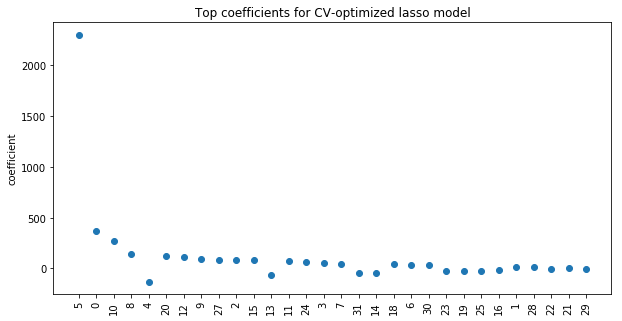

In [29]:
analyze_coef(X_train,lr,30)

In [30]:
lr_lasso=linear_model.LassoCV( fit_intercept=True,cv=10)
lr_lasso.fit(X_train,y_train)
lr_lasso.score(X_test,y_test)

0.17167896236518321

###  GLM Poission destribution for Comparesion Since the data is Right Skewed

In [31]:
import patsy

In [32]:
## X and y
X=final_nmf.iloc[:,:-1]
y=plot_video_comments_v3.number.reset_index().number

# Patsy does not like int columns so we have to transform them using this model
X.columns=[str('X')+str(i) for i in range (32)]

piosson_data_set=pd.concat([X,y],axis=1)
piosson_data_set.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,number
0,0.004599,0.173495,0.003696,0.0,0.040482,0.0,0.0,0.005661,0.0,0.000000,0.013659,0.0,0.0,0.034097,0.000000,0.0,0.0,0.030896,0.011179,0.0,0.0,0.000000,0.000000,0.0,0.056849,0.0,0.0,0.039327,0.0,0.0,0.007139,0.038925,132
1,0.033760,0.000000,0.000000,0.0,0.084492,0.0,0.0,0.000000,0.0,0.000000,0.151715,0.0,0.0,0.000000,0.205587,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.008367,51
2,0.168713,0.000000,0.000000,0.0,0.009017,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.001610,0.0,0.0,0.000000,0.000000,0.0,0.0,0.007637,0.027633,0.0,0.000000,0.0,0.0,0.007576,0.0,0.0,0.000000,0.000000,71
3,0.165926,0.008077,0.000000,0.0,0.000000,0.0,0.0,0.045771,0.0,0.009553,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.021225,0.013834,0.0,0.0,0.000000,0.000000,0.0,0.101856,0.0,0.0,0.000000,0.0,0.0,0.000000,0.011808,91
4,0.171492,0.000000,0.004559,0.0,0.000000,0.0,0.0,0.000000,0.0,0.007750,0.000000,0.0,0.0,0.000000,0.042983,0.0,0.0,0.009774,0.000000,0.0,0.0,0.020539,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.002566,83


##### Prep Data for Modeling

In [33]:
Y_p, X_p = patsy.dmatrices(
    'number ~ X0+X1+X2+X3+X4+X5+X6+X7+X8+X9+X10+X11+X12+X13+X14+X15+X16+X17+X18+X19+X20+X21+X22+X23+X24+X25+X26+X27+X28+X29+X30+X31',
    data=piosson_data_set,
    return_type="dataframe")

##### Model Data using GLM Models

In [34]:
pois_m=smf.GLM(Y_p,X_p, family=smf.families.Poisson(smf.families.links.log))
pois_results=pois_m.fit()
print (pois_results.summary())
type(pois_results)
## These coef needs to be e^coef to see the actual 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 number   No. Observations:                  816
Model:                            GLM   Df Residuals:                      783
Model Family:                 Poisson   Df Model:                           32
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -10889.
Date:                Tue, 05 Jun 2018   Deviance:                       17183.
Time:                        22:19:05   Pearson chi2:                 1.98e+04
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5574      0.022    160.103      0.000       3.514       3.601
X0             5.4240      0.109     49.547      0.0

statsmodels.genmod.generalized_linear_model.GLMResultsWrapper

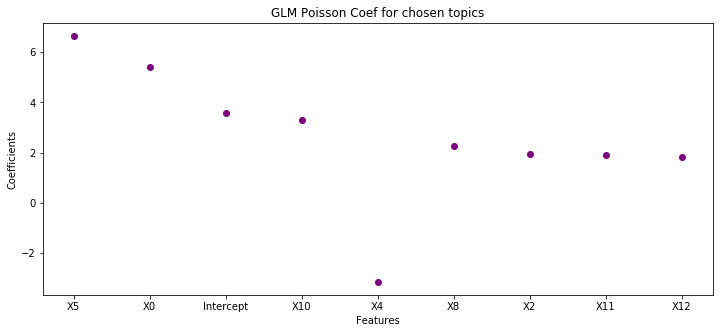

In [35]:
def analyze_coef2(df_with_cols,model,num_points):
    feat = df_with_cols.columns
    coef = pois_results.params
    sort_i = np.argsort(-np.abs(coef))

    plt.figure(figsize=(12,5))
    n_plot = num_points
    ind = np.arange(n_plot)
    plt.scatter(ind, coef[sort_i][:n_plot],c='purple')
    plt.xlabel('Features')
    plt.xticks(ind, feat[sort_i][:n_plot]);
    plt.title("GLM Poisson Coef for chosen topics")
    plt.ylabel("Coefficients")
    plt.savefig('coef_poisson.jpeg', format='jpeg', dpi=300)

analyze_coef2(X_p,pois_results.params,9)

### Prove that these Categories are optimal!
(Optional - Select Categories as needed) 

In [36]:
#Validation of created groups.  
plot_video_comments_v4 = plot_video_comments_v3.number.reset_index()
#Join both Comment frequency in time with  created groups!! Final DF ready to analyze. 
validate_groups = plot_video_comments_v4.join(final_nmf.outcome)

# test to see if chosen categories have higher values then rest of the categories. 

# categories filtered for selected features.
validate_groups_v1 = validate_groups[(validate_groups.outcome == 0)
                                     | (validate_groups.outcome == 8)
                                     | (validate_groups.outcome == 10)]

#Remove Selected features from Initial groups. 
validate_groups_v2 = validate_groups[(validate_groups.outcome != 0)]
validate_groups_v3 = validate_groups_v2[(validate_groups.outcome != 8)]
validate_groups_v4 = validate_groups_v3[(validate_groups.outcome != 10)]

#Compare Groups ratios based on comments mean!!
print((validate_groups_v1.number).mean(), validate_groups_v4.number.mean())


#(95.81147540983606, 52.12536023054755) without lamma!! 
# (85.91428571428571, 51.21528861154446) with lamma!

92.0 50.33384379785605


/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/honeybadger4/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


### Scatter plot to see the correlation between selected groups and Actual Video Time

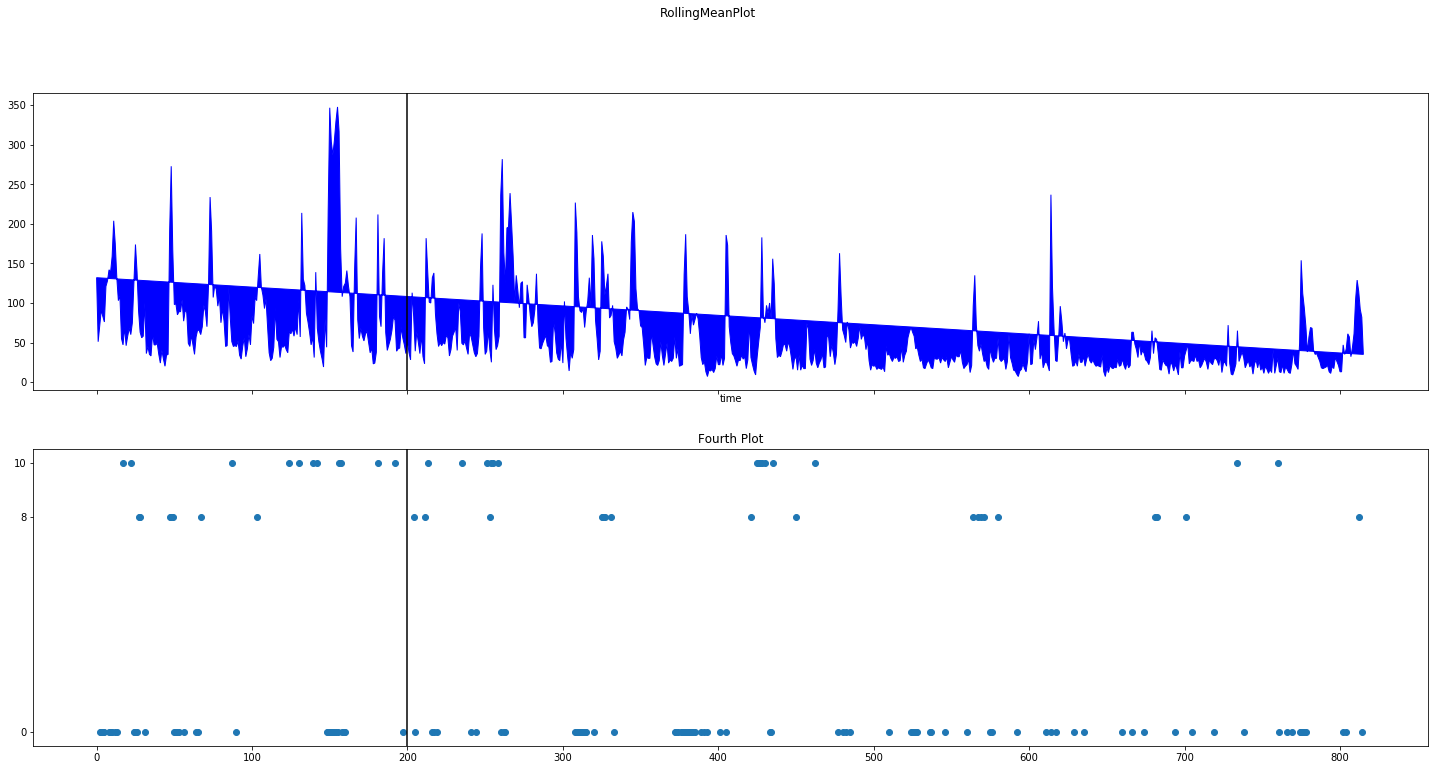

In [37]:

f, axarr = plt.subplots(2,figsize=(25, 12), sharex=True)
f.suptitle('RollingMeanPlot')
axarr[0].fill(validate_groups.index,validate_groups.number , c='blue')
axarr[1].scatter(validate_groups_v1.index,validate_groups_v1.outcome)
axarr[1].set_title('Fourth Plot')
axarr[1].set_yticks([0,10,8])

#Mark the play
axarr[0].axvline(x=200 , color='black');
axarr[1].axvline(x=200 , color='black');
# axarr[1].axhline(y=3, color="red")
axarr[0].set_xlabel('time')
plt.savefig('VideoTimeLine.jpeg', format='jpeg', dpi=300)
plt.rcParams.update({'font.size': 15})


#Number of comments overtime

### Unsupervised Learning K-Means Clustering

In [38]:
from sklearn.cluster import KMeans

In [39]:
model_k=KMeans(4).fit(matrix_topics_nmf)

In [40]:
(model_k.cluster_centers_)[0]

array([  1.97930424e-02,   1.93536870e-02,   1.65196170e-01,
         1.64363460e-03,   2.24814678e-02,   1.09690013e-05,
         7.28351115e-03,   8.28797398e-03,   5.04933534e-03,
         5.62633197e-03,   1.14016453e-02,   1.51899876e-02,
         1.14608570e-03,   8.83081678e-03,   9.72428005e-03,
         1.11836016e-02,   8.45627887e-03,   6.70641225e-03,
         8.97255646e-03,   1.71170762e-02,   2.76578879e-03,
         6.05104060e-03,   7.46353921e-03,   1.02014221e-02,
         5.89200604e-03,   1.00792619e-02,   7.92052418e-03,
         5.67440988e-03,   3.89405957e-03,   2.74274543e-02,
         4.34115704e-03,   1.59690794e-02])

In [41]:
len(model_k.labels_)

816

In [42]:
distortions = []
K = range(1,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(matrix_topics_nmf)
    kmeanModel.fit(matrix_topics_nmf)
    distortions.append(sum(np.min(scipy.spatial.distance.cdist(matrix_topics_nmf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / matrix_topics_nmf.shape[0])

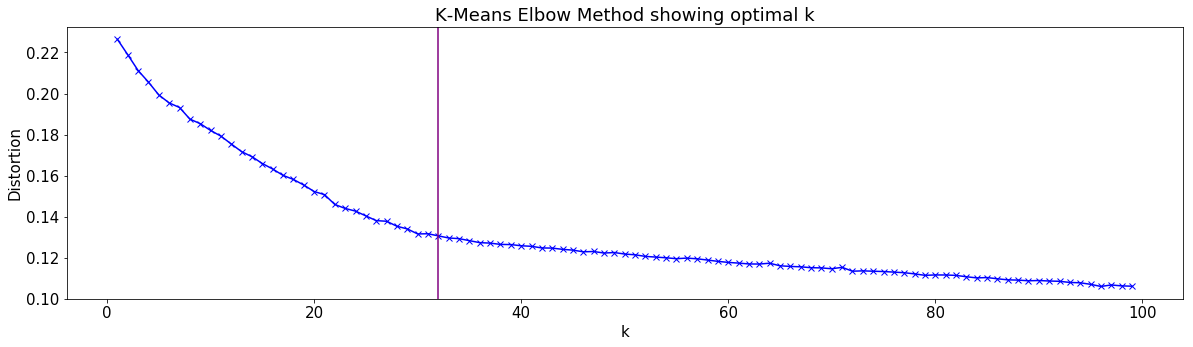

In [43]:
plt.figure(figsize=(20,5))
plt.plot(K, distortions, 'bx-', color='blue')
plt.xlabel('k')
plt.axvline(x=32 , color='purple');
plt.ylabel('Distortion')
plt.title('K-Means Elbow Method showing optimal k')
plt.savefig('kmeans.jpeg', format='jpeg', dpi=300)
plt.show()


### word cloud experiment: 

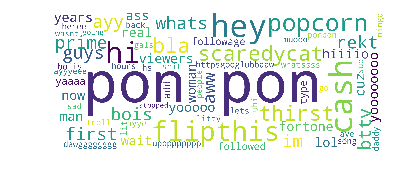

In [44]:
# for i in range(35,40):
wordcloud_str(df12.str_comments[2])

### TSNE Plot

In [45]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [46]:
tsneplot_len=1
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(topics_outcome_df_nmf)

In [47]:
from mpl_toolkits.mplot3d import Axes3D

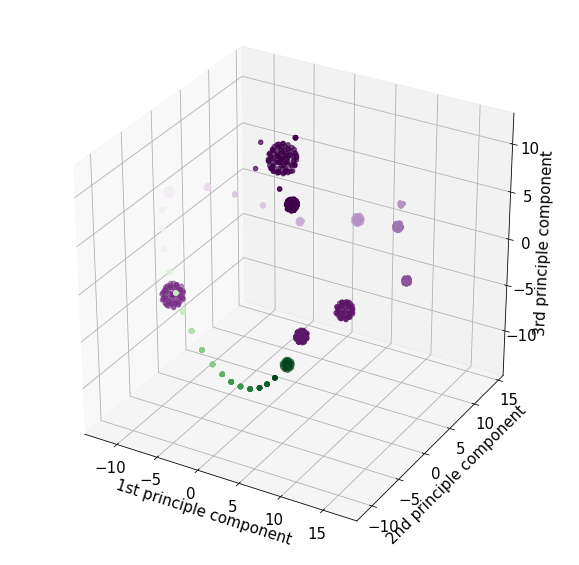

In [48]:
def plot_PCA_3D(data):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
#     ax = fig.gca(projection='3d')
    
    tsne = TSNE(n_components=3,metric="euclidean")
    X_tsne = tsne.fit_transform(data)


    ax.scatter(X_tsne[:, 0], X_tsne[:, 1],X_tsne[:, 2],c=topics_outcome_nmf  , cmap=plt.cm.get_cmap('PRGn', 20) )
    
    ax.set_xlabel('1st principle component')
    ax.set_ylabel('2nd principle component')
    ax.set_zlabel('3rd principle component')
    plt.savefig('3D Plot.jpeg', format='jpeg', dpi=300)
    plt.legend()
    
plot_PCA_3D(topics_outcome_df_nmf)

In [49]:
# 2D TSNE Plot, code not used

# plt.figure(figsize=(10,10))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=topics_outcome_nmf  , cmap=plt.cm.get_cmap('tab20_r', 20) )
# for a,b,i in zip(X_tsne[:, 0], X_tsne[:, 1],range(len(top_words))): 
#     plt.text(a,b,str(top_words[i])) 

#### 2D TSNE Plot, with Labels: 
-not useful, good code for future projects.

In [50]:
# from matplotlib import patches
# new_values = TSNE(metric='cosine',perplexity=40, n_components=2, n_iter=250).fit_transform(matrix_topics_nmf)
# x = []
# y = []
# labels = []

# num_topics = len(matrix_topics_nmf[0])
# for value in new_values:
#     x.append(value[0])
#     y.append(value[1])
# topics=[i for i in range(32)]
# cmap = plt.cm.get_cmap('nipy_spectral')
# cmapScale = int(cmap.N / num_topics)
# plt.figure(figsize=(30, 30),facecolor='white')
# labels = [] 
# for i in range(len(x)):
#     label = np.argmax(matrix_topics_nmf[i])
#     labels.append(label)
#     plt.scatter(x[i],y[i], c=cmap(label*cmapScale),s=100)

# color_legend = []
# for i in range(num_topics):
#     boolArr = np.array(labels) == i
#     x_avg = np.median(np.array(x)[boolArr])
#     y_avg = np.median(np.array(y)[boolArr])
#     plt.annotate(topics[i],
#                  xy=(x_avg, y_avg),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='center',
#                  va='center',
#                  fontsize=25,
#                  bbox=dict(boxstyle="round", fc="whitesmoke",alpha=0.7))
#     color_legend.append(patches.Patch(color=cmap(i*cmapScale), label=f'Topic #{i+1}: {topics[i]}'))
# # plt.legend(handles=color_legend,fontsize=18)
# # plt.axis('off')
# plt.ylim(.1,-.1)
# plt.xlim(.1,-.1)
# plt.show()